This is an experiment in merging neural networks with genetic algorithms, as a means to randomly discover (near-) optimal architecture, parameters, hyperparameters and activation functions for a given data set.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

%matplotlib inline
fig_size = [16, 9]
plt.rcParams['figure.figsize'] = fig_size

## Approach
To begin with, set some upper bounds on network size.
Express weights from each layer to the next as a matrix of the maximum possible size, but initialize as 0s (no actual connections between layers).  Start simple, with a single path from inputs, through the layers to outputs.  To begin with, create just a single hidden layer with up to 10 nodes.

Since there will be no cross-validation, the data set will be randomly generated at each iteration, but fro a defined dat-generating process, in order to reduce overfitting.

## Data generation

In [5]:
def generate_data(n = 100000):
    a = 10 * np.random.random(n) + 10
    b = 10 * np.random.random(n) + 10
    c = 10 * np.random.random(n) + 10
    d = 10 * np.random.random(n) + 10
    X = np.column_stack((a, b, c, d))
    Y = (7 + 0.3 * a ** 0.87 + np.sin(b) - c * b - d ** -a + np.log(c) + 
         10 * np.random.randn(n))
    return X, Y

In [8]:
def plot_y_by(X, Y):
    alpha = 0.005
    f, axarr = plt.subplots(3, 2);
    axarr[0, 0].scatter(X[:, 0], Y, alpha = alpha);
    axarr[0, 0].set_title('y ~ a');
    axarr[0, 1].scatter(X[:, 1], Y, alpha = alpha);
    axarr[0, 1].set_title('y ~ b');
    axarr[1, 0].scatter(X[:, 2], Y, alpha = alpha);
    axarr[1, 0].set_title('y ~ c');
    axarr[1, 1].scatter(X[:, 3], Y, alpha = alpha);
    axarr[1, 1].set_title('y ~ d');
    axarr[2, 0].scatter(np.sin(X[:, 1]), Y, alpha = alpha);
    axarr[2, 0].set_title('y ~ sin(b)');
    axarr[2, 1].scatter(
        (7 + 0.3 * X[:, 0] ** 0.87 + np.sin(X[:, 1]) - X[:, 2] * X[:, 1] - 
         X[:, 3] ** -X[:, 0] + np.log(X[:, 2])), 
        Y, 
        alpha = alpha);
    axarr[2, 1].set_title('y ~ generating_function');

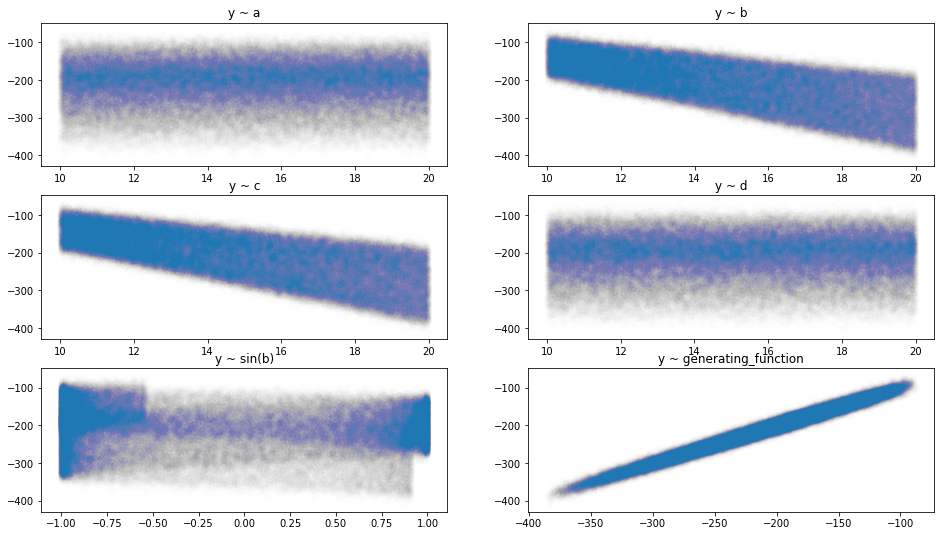

In [9]:
X, Y = generate_data()
plot_y_by(X, Y)

## Define Network Features
Here the network is defined as having 4 inputs (columns of X), a single hidden layer with no more than 10 nodes, biases at input and hidden layer, and activation functions at each node of the hidden layer (randomly selected as sigmoid, hyperbolic tangent, relu, or None.

Since there is no backprop, the biases are merged with their layers, and will be assumed to be index 0.

In [10]:
# Initialize weights
N = 100000                    # number of data records
D = 4                         # input units
M = 10                        # (max) hidden units
K = 1                         # outputs in Y
W1 = np.zeros([D + 1, M + 1]) # X (plus bias) -> hidden
W2 = np.zeros([M + 1, K])     # hidden (plus bias) -> Y (Y is one-dim here)

In [11]:
print('W1:\n', W1)
print('\nW2:\n', W2)

W1:
 [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]

W2:
 [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


In [12]:
def cost(pred, Y):
    # Sum of squared errors
    return ((pred - Y) ** 2).sum()

In [13]:
print('median(Y):', np.median(Y))

median(Y): -205.412583036


In [14]:
# Test-- baseline cost function: guess all values as median
base_med = cost([np.median(Y)] * N, Y)
base_mean = cost([np.mean(Y)] * N, Y)

print(base_med)
print(base_mean)

393240366.501
388136238.143


### Restrictions
* There must be, minimally, one path from X -> hidden -> Y, so there must be at least 1 nonzero value in W1 (W1[i, j]) and at least 1 non-zero value in W2 (W2[j])
* There can be no inputs to the biases

## The "Chromosome"
The "chromosome" for each network that defines the network parameters, mutates, and "breeds" will be defined as an object containing:
* W1 (Real(D + 1, M + 1)
* W2 (Real(M + 1)
* activation function (set(sigmoid, tanh, relu, None))

In [15]:
def add_bias_column(M):
    '''Adds a column of 1s as the new leftmost column of matrix M'''
    bias = np.ones((M.shape[0], 1))
    return np.append(bias, M, axis = 1)

In [19]:
class Chromosome:
    activations = ['sigmoid', 'tanh', 'relu']
    # TODO: Update for arbitrary number of hidden layers
    def __init__(
        self, parent, D, M, K, mutation_rate, use_activation = True):
        
        self.mutation_rate = mutation_rate
        self.D = D
        self.M = M
        self.K = K
        self.activation = None
        self.use_activation = use_activation
        if parent:
            self.W1 = self.mutate(parent.W1, self.mutation_rate)
            self.W2 = self.mutate(parent.W2, 
                                  self.mutation_rate, 
                                  to_Y = True, 
                                  previous_mat = self.W1)
            if use_activation:
                self.activation = self.mutate_activation(parent.activation)
            else:
                self.activation = None
        else:
            #print('Initiating W1')
            self.W1 = self.init_matrix(self.D + 1, self.M)
            #print('Initiating W2')
            self.W2 = self.init_matrix(self.M + 1, 
                                       self.K, 
                                       to_Y = True, 
                                       previous_mat = self.W1)
            if use_activation:
                self.activation = np.random.choice(self.activations, 1)[0]
            else:
                self.activation = None
            
    def __str__(self):
        return (
            'D: %d\tM: %d\tK: %d\nActivation: %s\nW1:\n%r\nW2:\n%r' 
            %(self.D, self.M, self.K, self.activation, self.W1, self.W2))
            
    def init_matrix(self, 
                    I, 
                    J, 
                    to_Y = False, 
                    previous_mat = None, 
                    method = 'Xavier_normal'):
        '''Create an I x J matrix initiatied according to "method"'''
        sigma = np.sqrt(2 / (I + J))
        range_bound  = np.sqrt(6 / (I + J))
        
        if method == 'Xavier_normal':
            mat = np.random.normal(scale = sigma, size = (I , J))
        elif method == 'Xavier_uniform':
            mat = np.random.uniform(
                -range_nbound, range_bound, size = (I, J))
        elif method == 'Simple':
            mat = np.zeros([I, J])
            self.mutate(mat, 
                        self.mutation_rate, 
                        to_Y = to_Y, 
                        previous_mat = previous_mat)
        if method != 'Simple':
            if self.activation == 'tanh':
                mat *= 4
            elif self.activation == 'relu':
                mat *= np.sqrt(2)
        return mat
        
    def mutate(self,
               mat, 
               mutation_rate, 
               threshold = 0.00001, 
               max_weight = 1e+7, 
               to_Y = False,
               previous_mat = None):
        '''
        Randomly select a weight and multiply it by a random value on
        [1 / mutation_rate, mutation_rate].  
        If value is 0, randomly initialize to 1 or -1.
        If abs value of new weight < threshold, set to 0
        '''
        factor = ((mutation_rate - 1 / mutation_rate) * 
                  np.random.random(1) + 1 / mutation_rate)[0]
        I, J = mat.shape
        #print(mat)
        #print(I, 'x', J)

        # If there is a previous matrix, it only makes sense to have
        # outputs from nodes that have inputs (or the bias)
        if previous_mat is not None:
            #print('previous_mat:\n', previous_mat)
            col_sums = previous_mat.sum(axis = 0)
            #print('col_sums:\n', col_sums)
            i = np.where(col_sums != 0)[0]
            #print('possible indices:', i)
            i = np.random.choice(i)
            #print('chosen index:', i)
        else:
            i = np.random.choice(range(I), 1)[0]
                    
        j = np.random.choice(range(J), 1)[0]
        
        # If currently 0, turn to 1 or -1
        if mat[i, j] == 0:
            mat[i, j] = [-1, 1][random.randrange(0, 2)]
        else:
            mat[i, j] *= factor

            # Prevent overflow by capping max
            mat[i, j] = np.min([mat[i, j], max_weight])

            # If abs(M[i, j]) < threshold, reset to 0 to prevent underflow
            if np.abs(mat[i, j]) < threshold:
                mat[i, j] = 0

        return mat
    
    def mutate_activation(self, a):
        resample = np.random.choice([True, False], 1)
        if resample:
            return np.random.choice(self.activations, 1)[0]
        return a
    
    def forward(self, X):
        #print('X (%d x %d)' %(X.shape[0], X.shape[1]))
        # add bias
        X = add_bias_column(X)
        #print('X + bias (%d x %d)' %(X.shape[0], X.shape[1]))
        #print('W1 (%d x %d)' %(self.W1.shape[0], self.W1.shape[1]))
        Z1 = np.dot(X, self.W1)
        #print('Z1 (%d x %d)' %(Z1.shape[0], Z1.shape[1]))
        if self.activation:
            Z1 = activate(Z1, self.activation)
        
        # Next layer
        Z1 = add_bias_column(Z1)
        #print('Z1 + bias (%d x %d)' %(Z1.shape[0], Z1.shape[1]))
        #print('W2 (%d x %d)' %(self.W2.shape[0], self.W2.shape[1]))
        Z2 = np.dot(Z1, self.W2)
        #print('Z2 (%d x %d)' %(Z2.shape[0], Z2.shape[1]))
        if self.activation:
            Z2 = activate(Z2, self.activation) # or softmax if out
        return Z2
         
    # For regression models, sse will be used as cost function
    def sse(self, Y):
        return ((Y - self.predictions.T[0]) ** 2).sum()

In [20]:
def copy_Chromosome(chrom):
    copy = Chromosome(parent = None,
                      D = chrom.D,
                      M = chrom.M,
                      K = chrom.K,
                      mutation_rate = chrom.K,
                      use_activation = chrom.use_activation)
    copy.W1 = chrom.W1
    copy.W2 = chrom.W2
    return copy

In [21]:
test = Chromosome(parent = None, 
                  D = 4, 
                  M = 10,
                  K = 1, 
                  mutation_rate = 3, 
                  use_activation = False)
print(test)

D: 4	M: 10	K: 1
Activation: None
W1:
array([[ 0.10352407, -0.11804807,  0.17701102,  0.3762282 ,  0.31238881,
        -0.31215627,  0.00393932, -0.30293585, -0.19599247,  0.017333  ],
       [-0.27878468, -0.02472939, -0.22191128, -0.18442785,  0.90959597,
         0.43046014, -0.25956   , -0.0994718 , -0.77989775,  0.15792062],
       [-0.13051256, -0.19735452, -0.14729162,  0.25801556,  0.25961014,
        -0.36441758, -0.51337886,  0.0499366 , -0.16993862, -0.16999868],
       [-0.00780707,  0.22788983, -0.10928089, -0.5066818 , -0.09607535,
         0.07768943, -0.29191448, -0.21450313,  0.64330781, -0.23661582],
       [ 0.29146481, -0.03977573, -0.08332078,  0.17142887, -0.18271812,
         0.3579697 ,  0.0878616 , -0.39197176,  0.31803696, -0.17389255]])
W2:
array([[ 0.2479963 ],
       [-0.08614542],
       [-0.50717124],
       [-0.40622648],
       [-0.23194477],
       [-0.19941826],
       [-0.01291212],
       [ 0.31237623],
       [ 0.30577322],
       [ 1.16982182],
   

In [22]:
for i in range(10):
    test = Chromosome(parent = test, 
                      D = 4, 
                      M = 10, 
                      K = 1, 
                      mutation_rate = 3, 
                      use_activation = False)
    print('\n\nGeneration:', i + 2)
    print(test)



Generation: 2
D: 4	M: 10	K: 1
Activation: None
W1:
array([[ 0.10352407, -0.11804807,  0.17701102,  0.3762282 ,  0.31238881,
        -0.31215627,  0.00393932, -0.30293585, -0.19599247,  0.017333  ],
       [-0.27878468, -0.02472939, -0.22191128, -0.18442785,  0.90959597,
         0.43046014, -0.25956   , -0.0994718 , -0.77989775,  0.15792062],
       [-0.13051256, -0.41081466, -0.14729162,  0.25801556,  0.25961014,
        -0.36441758, -0.51337886,  0.0499366 , -0.16993862, -0.16999868],
       [-0.00780707,  0.22788983, -0.10928089, -0.5066818 , -0.09607535,
         0.07768943, -0.29191448, -0.21450313,  0.64330781, -0.23661582],
       [ 0.29146481, -0.03977573, -0.08332078,  0.17142887, -0.18271812,
         0.3579697 ,  0.0878616 , -0.39197176,  0.31803696, -0.17389255]])
W2:
array([[ 0.2479963 ],
       [-0.08614542],
       [-0.50717124],
       [-0.40622648],
       [-0.23194477],
       [-0.19941826],
       [-0.01291212],
       [ 0.31237623],
       [ 0.77692021],
       [ 

In [23]:
def breed_matrices(M1, M2, method):
    '''M1 will be "bred" with M2 then the new matrix is returned'''
    child = np.zeros(M1.shape)
    r = M1.shape[0] # nrow
    c = M1.shape[1] # ncol
    
    for i in range(r):
        for j in range(c):
            if method == 'random_select':
                child[i, j] = np.random.choice([M1[i, j], M2[i, j]])
            elif method == 'average':
                child[i, j] = np.mean([M1[i, j], M2[i, j]])
    
    # Matrix must have at least one non-zero value:
    if (child == 0).sum() == r * c:
        i = np.random.randint(0, r)
        j = np.random.randint(0, c)
        child[i, j] = np.random.choice([-1, 1])
        
    return child

In [24]:
def breed(chrom1, chrom2, method):
    child = Chromosome(parent = None, 
                       D = chrom1.D, 
                       M = chrom1.M, 
                       K = chrom1.K, 
                       mutation_rate = chrom1.mutation_rate,
                       use_activation = chrom1.use_activation)
    # Update weight matrices
    child.W1 = breed_matrices(chrom1.W1, chrom2.W1, method)
    child.W2 = breed_matrices(chrom1.W2, chrom2.W2, method)
    return child

In [25]:
test1 = Chromosome(parent = None, 
                   D = 4, 
                   M = 10,
                   K = 1, 
                   mutation_rate = 3, 
                   use_activation = False)
test2 = Chromosome(parent = None, 
                   D = 4, 
                   M = 10,
                   K = 1, 
                   mutation_rate = 3, 
                   use_activation = False)
offspring1 = breed(test1, test2, method = 'random_select')
offspring2 = breed(test1, test2, method = 'average')

print('t1:\n', test1)
print('t2:\n', test2)
print('\noffspring1:\n', offspring1)
print('\noffspring2:\n', offspring2)

t1:
 D: 4	M: 10	K: 1
Activation: None
W1:
array([[-0.6526595 , -0.30384966, -0.0998011 ,  0.65161201, -0.34120395,
         0.33733648,  0.14578864, -0.68359006,  0.01348087,  0.11626185],
       [ 0.03181883,  0.26651241,  0.16917054, -0.07088807, -0.49137901,
         0.3001698 , -0.63518185, -0.3790749 , -0.33004025, -0.88196167],
       [-0.57127846,  0.2538031 ,  0.34003024,  0.23747045,  0.0481686 ,
        -0.45221385,  0.02685044,  0.44461368, -0.98481851, -0.0122801 ],
       [ 0.30365625, -0.50161785,  0.39030945,  0.04483227, -0.76381732,
         0.3165944 ,  0.34912993,  0.07039298,  0.48127064,  0.405682  ],
       [ 0.40102249,  0.24324305,  0.04238171,  0.33048005, -0.0508222 ,
         0.6560244 ,  0.07999114, -0.46606977, -0.65767285, -0.28930394]])
W2:
array([[ 0.47535922],
       [-0.19516507],
       [ 0.11486883],
       [-0.24074845],
       [ 0.00653153],
       [-0.49080411],
       [ 0.13000178],
       [-0.58982191],
       [-0.70031099],
       [-0.21547556]

In [26]:
offspring1.predictions = offspring1.forward(X)

In [27]:
offspring1.error = offspring1.sse(Y)
offspring1.error
#e = Y - offspring1.predictions
#Y
#Y - offspring1.predictions.T[0]

5055225649.7807541

# Run for Multiple Generations and Track Progress
* Initialization: create `n_cohort` new Chromosomes
* Select the 2 best
* Breed the 2 best (both methods)
* Mutate the 2 best `(n_cohort - 2) / 2` times to create offspring
* Record best score per generation, average score per generation, and best score yet
* Repeat `n_generations` times

In [28]:
def genetic(generations, 
            D, 
            M, 
            K, 
            mutation_rate = 3, 
            print_at_iters = 100, 
            verbose = True):
    best_per_generation = []
    median_per_generation = []
    best_yet = []    

    X, Y = generate_data()

    # Initial cohort
    cohort = [Chromosome(parent = None, 
                         D = D, 
                         M = M,
                         K = K, 
                         mutation_rate = mutation_rate, 
                         use_activation = False)
              for chrom in range(n_cohort)]

    for generation in range(n_generations):
        X, Y = generate_data()


        # Get predictions and errors
        for chrom in cohort:
            chrom.predictions = chrom.forward(X)
            chrom.error = chrom.sse(Y)

        # Track statistics
        errors = [chrom.error for chrom in cohort]
        best_per_generation.append(np.min(errors))
        median_per_generation.append(np.median(errors))
        if generation == 0:
            best_yet.append(best_per_generation[-1])
        else:
            best_yet.append(np.min([best_yet[-1], best_per_generation[-1]]))

        # Reproduce
        best2idx = np.argpartition(errors, 2)[:2]

        # Breed the two best:
        mom = cohort[best2idx[0]]
        dad = cohort[best2idx[1]]
        c1 = breed(mom, dad, method = 'random_select')
        c2 = breed(mom, dad, method = 'average')


        mom_mutes = [Chromosome(parent = copy_Chromosome(mom), 
                                D = D, 
                                M = M,
                                K = K, 
                                mutation_rate = mutation_rate, 
                                use_activation = False)
                     for mute in range((n_cohort - 4) // 2)]
        dad_mutes = [Chromosome(parent = copy_Chromosome(dad), 
                                D = D, 
                                M = M,
                                K = K, 
                                mutation_rate = mutation_rate, 
                                use_activation = False)
                     for mute in range((n_cohort - 4) // 2)]
        cohort = [mom, dad, c1, c2]
        for mute in mom_mutes:
            cohort.append(mute)
        for mute in dad_mutes:
            cohort.append(mute)
            
        if verbose and generation % print_at_iters == 0:
            print('Generation: %d\tBest Error: %.3f' 
                  %(generation, best_yet[-1]))
            
    print('Generation: %d\tBest Error: %.3f' %(generation, best_yet[-1]))  
    return { 'best': mom,
             'best_per_generation': best_per_generation,
             'best_yet': best_yet,
             'median_per_generation': median_per_generation}

In [29]:
n_cohort = 20
n_generations = 1000
mutation_rate = 50


# Graph properties
D = 4
M = 100
K = 1

run = genetic(generations = n_generations, 
              D = D, 
              M = M, 
              K = K)

Generation: 0	Best Error: 4636235267.046
Generation: 100	Best Error: 112444228.993
Generation: 200	Best Error: 74669469.281
Generation: 300	Best Error: 57080167.740
Generation: 400	Best Error: 56155283.808
Generation: 500	Best Error: 55953881.068
Generation: 600	Best Error: 55953881.068
Generation: 700	Best Error: 51353760.659
Generation: 800	Best Error: 40971724.364
Generation: 900	Best Error: 39698867.827


In [30]:
run['best_yet'][-1]

39468588.335025728

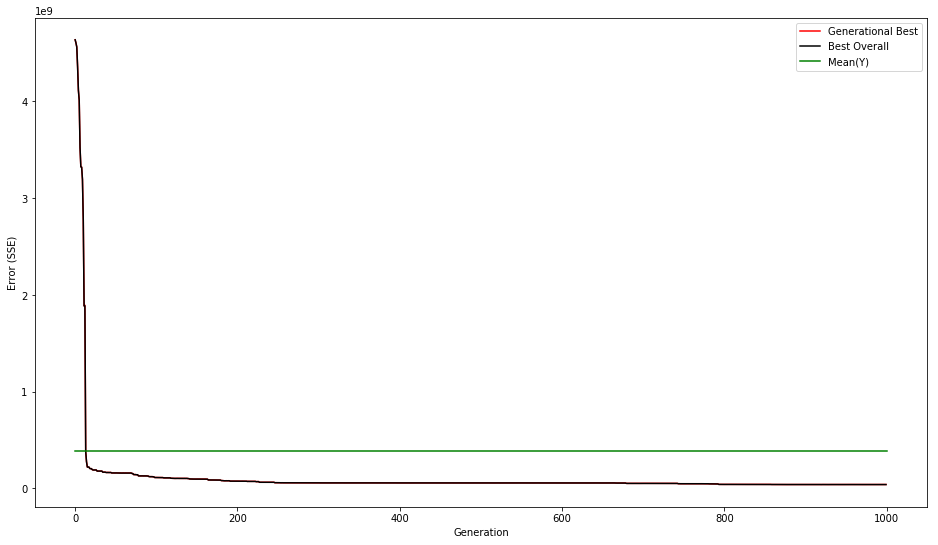

In [33]:
# Best seen: 39468588.335
plt.plot(run['best_per_generation'], 'r', label = 'Generational Best');
#plt.plot(run['median_per_generation'], 'b', label = 'Generation Median');
plt.plot(run['best_yet'], 'k', label = 'Best Overall');
plt.xlabel('Generation');
plt.ylabel('Error (SSE)');
plt.plot(
    [0, n_generations], [base_mean, base_mean], 'g-', label = 'Mean(Y)');
plt.legend(loc = 'best');

In [34]:
# Average error per data point
print(np.sqrt(run['best_yet'][-1] / 100000))

19.8667028807


In [35]:
print(run['best'])

D: 4	M: 100	K: 1
Activation: None
W1:
array([[  1.22516031e-01,  -1.38564039e+00,   3.14006497e-01,
          1.60852204e-01,  -1.17395643e-02,   1.11125016e-01,
         -9.49247677e-02,   5.80801324e-01,   3.44827596e-01,
         -1.14620798e+00,  -7.98008425e-02,  -1.56006886e+00,
         -3.96425877e-01,  -8.83266177e-02,   4.20950162e-01,
         -2.21292107e-01,  -5.60885850e+00,   1.14615486e-01,
         -4.09707637e-02,   3.19553505e-02,  -1.94090194e-01,
          3.14842139e-02,  -9.98313376e-03,   5.89801430e-02,
          1.01521019e-01,  -1.78019851e-01,   1.11205275e+00,
         -1.14747091e-01,  -2.70695196e-02,  -6.83065124e-01,
          1.15307227e-01,   7.64318623e-02,  -1.51281340e-01,
         -1.68631571e-01,   1.54155295e-02,  -5.93488540e-01,
          4.99945057e-02,   1.41903796e-01,  -2.75730618e-01,
         -1.00740867e+00,   7.74280480e-02,   5.96160459e-02,
         -1.02280613e+00,  -1.20734337e-02,   3.64601514e-02,
          2.76212767e-01,   1.14